This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Advanced deep learning for computer vision

## Three essential computer vision tasks

## An image segmentation example

In [1]:
# import urllib.request
# urls = [
#     "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
#     "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
# ]

# for url in urls:
#     filename = url.split("/")[-1]
#     print(f"Downloading {filename}...")

#     urllib.request.urlretrieve(url, filename)

#     print(f"Downloaded {filename}")

In [2]:
# import tarfile

# # List of tar files
# tar_files = ["images.tar.gz", "annotations.tar.gz"]

# # Extract each file
# for tar_path in tar_files:
#     print(f"Extracting {tar_path}...")

#     with tarfile.open(tar_path, "r:gz") as tar:
#         tar.extractall(path="../DL_data/pets")

#     print(f"Extracted {tar_path}")

In [3]:
import os

input_dir = "../DL_data/pets/images"
target_dir = "../DL_data/pets/annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

7390


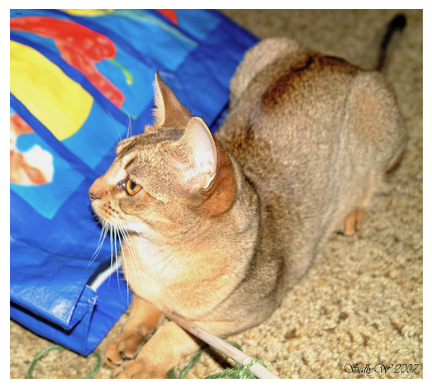

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
print(len(input_img_paths))
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

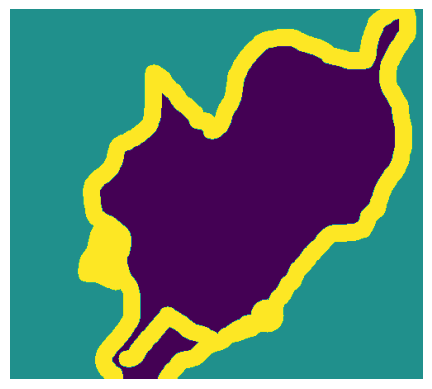

In [5]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [6]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 447s 4s/step - loss: 0.9719 - val_loss: 0.8874
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 434s 4s/step - loss: 0.8812 - val_loss: 0.8103
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - loss: 0.8238 - val_loss: 0.8374
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - loss: 0.8081 - val_loss: 0.7751
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - loss: 0.7918 - val_loss: 0.7687
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - loss: 0.7623 - val_loss: 0.7470
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - loss: 0.7551 - val_loss: 0.7093
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - loss: 0.7288 - val_loss: 0.6520
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - loss: 0.6816 - val_loss: 0.6193
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - loss: 0.6563 - val_loss: 0.6783
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - loss: 0.6309 - val_loss: 0.5804
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 

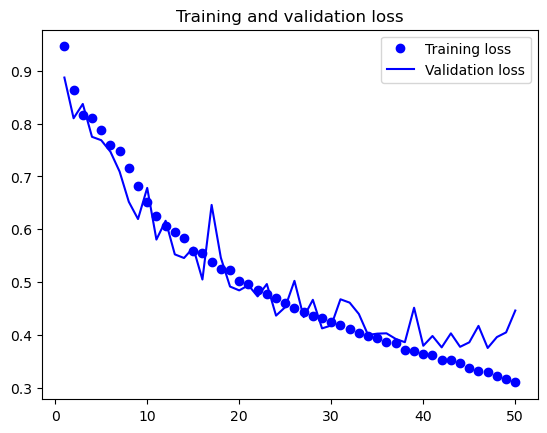

In [9]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


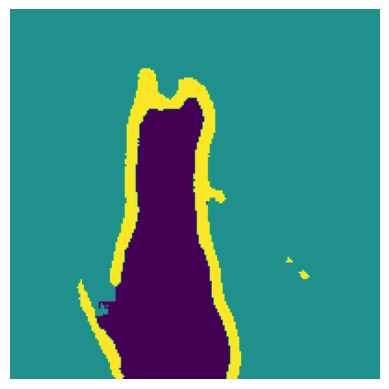

In [10]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

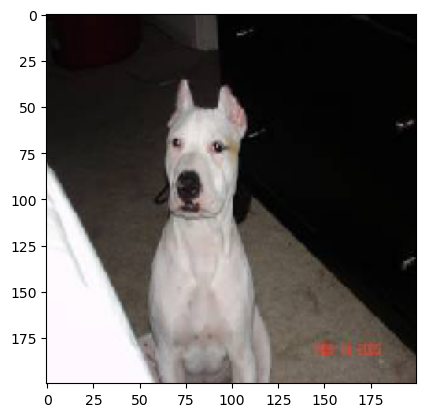

In [11]:
plt.imshow(test_image.astype("uint8"))

mistakes the white cloth as a border of the dog and extends a little far. There is also some noise on the black near the dog's neck, many pets in training are black and white so this would make sense.

Additional noise out away from the dog will be difficult to correct without overtraining. The model does a good job identifying the dog, background, and border between. A deeper network would likely give us better results.